### https://www.kaggle.com/competitions/drawing-with-llms

In [1]:
import kagglehub
import pandas as pd

train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')
train = pd.read_csv(train_path)

train.head()

,id,description
0,04c411,a starlit night over snow-covered peaks
1,215136,black and white checkered pants
2,3e2bc6,crimson rectangles forming a chaotic grid
3,61d7a8,burgundy corduroy pants with patch pockets and...
4,6f2ca7,orange corduroy overalls


In [2]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = (
    None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
)
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",  # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",  # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit",  # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",  # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",  # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",  # Gemma 2x faster!
]  # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4070 Ti SUPER. Max memory: 15.693 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [3]:
import re
import json
from unsloth.chat_templates import get_chat_template

# Define your tokenizer with a flexible chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template="chatml",  # Flexible for multiple models (Zephyr, LLaMA, Mistral, etc.)
    mapping={
        "role": "from", 
        "content": "value", 
        "user": "human", 
        "assistant": "gpt"
    },
    map_eos_token=True,  # Ensures <|im_end|> maps to </s> for end-of-sentence
)

# Enable faster inference (2x speed up)
FastLanguageModel.for_inference(model)

def get_svg_code(text):
    """
    This function generates a minimal, valid SVG based on the provided text input.
    """

    # Structured chat template for SVG generation request
    messages = [
        {
            "from": "system", 
            "value": "You are a helpful assistant specialized in generating minimal, valid SVG code"
        },
        {
            "from": "human", 
            "value": f"Now, create an SVG based on the following topic: {text}"
        }
    ]
    
    # Apply the tokenizer and prepare the inputs for the model
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        padding=True,
        truncation=False,
        add_generation_prompt=True,  # Necessary for generation to work
        return_tensors="pt",
    ).to("cuda")
    
    # Create an attention mask to avoid padding interference during inference
    attention_mask = (inputs != tokenizer.pad_token_id).int() 

    # Generate output using the model
    outputs = model.generate(
        input_ids=inputs,
        attention_mask=attention_mask,
        temperature=0.5,  # Low temperature for deterministic results
        max_new_tokens=2048,  # Adjust max tokens if needed
        use_cache=True
    )
    
    # Decode and return the unformatted output (processed into a clean response)
    unformatted_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return unformatted_output



Unsloth: Will map <|im_end|> to EOS = <|eot_id|>.


In [4]:
train['response']=train['description'].apply(get_svg_code)

In [5]:
# # We can play with our Model and render its SVG output (don't export!)
# from IPython.display import SVG, display
# display(SVG(tmp))

In [6]:
## Ref: https://www.kaggle.com/code/ryanholbrook/drawing-with-llms-getting-started-with-gemma-2

import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):

        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
        <constraints>
        * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
        * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
        </constraints>
        
        <example>
        <description>"A red circle with a blue square inside"</description>
        ```svg
        <svg viewBox="0 0 256 256" width="256" height="256">
          <circle cx="50" cy="50" r="40" fill="red"/>
          <rect x="30" y="30" width="40" height="40" fill="blue"/>
        </svg>
        ```
        </example>
        
        
        Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.
        
        <description>"{}"</description>
        ```svg
        <svg viewBox="0 0 256 256" width="256" height="256">
        """
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:

            return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg


This code could modify your python environment or operating system.

Review this code at https://www.kaggle.com/code/metric/svg-constraints/versions/1
or in your download cache at /home/vino/.cache/kagglehub/notebooks/metric/svg-constraints/output/versions/1

It is strongly recommended that you run this code within a container
such as Docker to provide a secure, isolated execution environment.
See https://www.kaggle.com/docs/packages for more information.

Do you want to proceed? (y)es/[no]:  y


In [8]:
import re

default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""

# Assuming train is a DataFrame with an existing 'svg_code' column
train['svg_code'] = default_svg  # Initialize the 'clean_svg_code' column with the default SVG

# Iterate over the first 15 rows in the 'svg_code' column
for i in range(15):
    # Regex to extract all SVGs from the string in the 'svg_code' column
    svg_matches = re.findall(r'\n(<svg.*?</svg>)\n', train.loc[i, 'response'], re.DOTALL)
    
    # Check if any SVGs were found
    if svg_matches:
        # Update with the last SVG in the matches (if there are multiple)
        train.loc[i, 'svg_code'] = svg_matches[-1]

    else:
        # If no SVG is found, keep the default SVG
        train.loc[i, 'svg_code'] = default_svg



In [9]:
train['svg_code']

0     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
1     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
2     <svg width="600" height="600" viewBox="0 0 600...
3     <svg width="256" height="256" viewBox="0 0 256...
4     <svg xmlns="http://www.w3.org/2000/svg" width=...
5     <svg width="400" height="400" viewBox="0 0 400...
6     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
7     <svg xmlns="http://www.w3.org/2000/svg" width=...
8     <svg width="256" height="256" viewBox="0 0 256...
9     <svg width="256" height="256" viewBox="0 0 256...
10    <svg width="300" height="300" xmlns="http://ww...
11    <svg width="200" height="300">\n  <rect x="0" ...
12    <svg xmlns="http://www.w3.org/2000/svg" width=...
13    <svg width="400" height="400" viewBox="0 0 400...
14    <svg width="100%" height="100%" viewBox="0 0 1...
Name: svg_code, dtype: object

In [10]:
model=Model()

In [17]:
train['svg_code_clean']=train['svg_code'].copy()
for i in range(15):
    train.loc[i,'svg_code_clean']=model.enforce_constraints(train.loc[i,'svg_code'])
    print(train.loc[i,'svg_code_clean'])
    print('--' * 30)

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1000 1000" width="1000" height="1000"><rect x="0" y="0" width="1000" height="1000" fill="#2c3e50" rx="10"/><rect x="0" y="0" width="1000" height="1000" fill="#1a1d23" opacity="0.5" rx="10"/><circle cx="500" cy="500" r="2" fill="#fff"/><circle cx="550" cy="550" r="2" fill="#fff"/><circle cx="600" cy="600" r="2" fill="#fff"/><circle cx="650" cy="650" r="2" fill="#fff"/><circle cx="700" cy="700" r="2" fill="#fff"/><circle cx="750" cy="750" r="2" fill="#fff"/><circle cx="800" cy="800" r="2" fill="#fff"/><circle cx="850" cy="850" r="2" fill="#fff"/><circle cx="900" cy="900" r="2" fill="#fff"/><circle cx="950" cy="950" r="2" fill="#fff"/><circle cx="500" cy="450" r="30" fill="#fff"/></svg>
------------------------------------------------------------
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 100"><rect x="0" y="0" width="100%" height="100%" fill="#000000"/><rect x="0" y="0" width="50%" height="100%" fill="#FFFFFF" rx="10"/><r

In [15]:
train

,id,description,response,clean_svg_code,svg_code,svg_code_clean
0,04c411,a starlit night over snow-covered peaks,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo..."
1,215136,black and white checkered pants,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo..."
2,3e2bc6,crimson rectangles forming a chaotic grid,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""600"" height=""600"" viewBox=""0 0 600...","<svg width=""600"" height=""600"" viewBox=""0 0 600..."
3,61d7a8,burgundy corduroy pants with patch pockets and...,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256..."
4,6f2ca7,orange corduroy overalls,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg xmlns=""http://www.w3.org/2000/svg"" width=...","<svg xmlns=""http://www.w3.org/2000/svg"" width=..."
5,8066ae,a lighthouse overlooking the ocean,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""400"" height=""400"" viewBox=""0 0 400...","<svg width=""400"" height=""400"" viewBox=""0 0 400..."
6,828a8f,a green lagoon under a cloudy sky,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo...","<svg xmlns=""http://www.w3.org/2000/svg"" viewBo..."
7,98f11f,a snowy plain,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg xmlns=""http://www.w3.org/2000/svg"" width=...","<svg xmlns=""http://www.w3.org/2000/svg"" width=..."
8,9ce3c4,a maroon dodecahedron interwoven with teal thr...,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256..."
9,a9ecbb,a purple silk scarf with tassel trim,<|im_start|>system\nYou are a helpful assistan...,"<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256...","<svg width=""256"" height=""256"" viewBox=""0 0 256..."


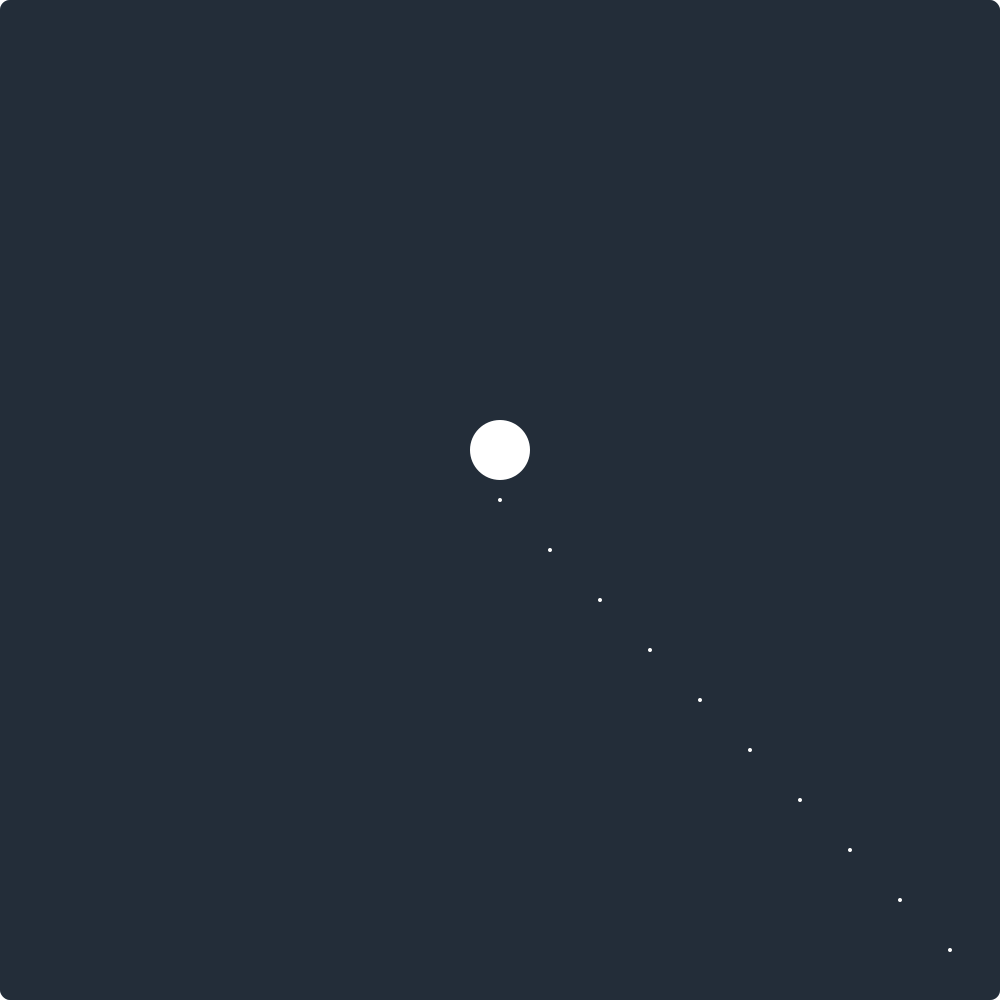

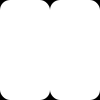

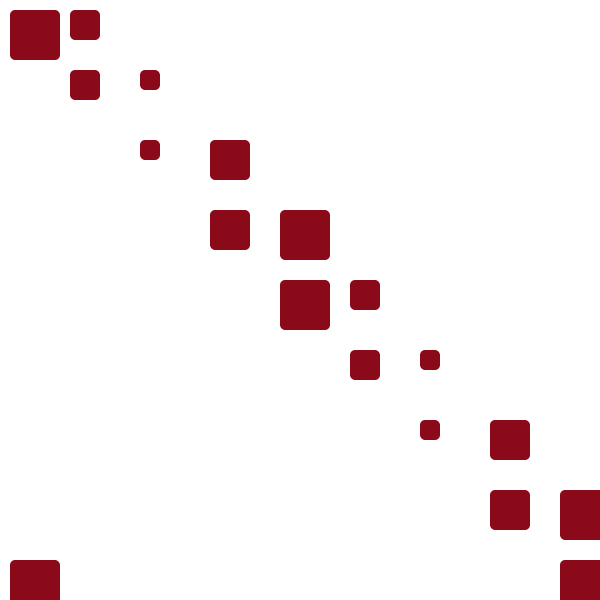

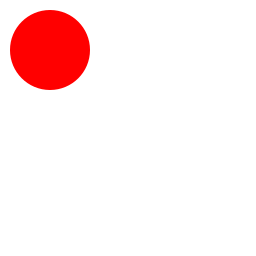

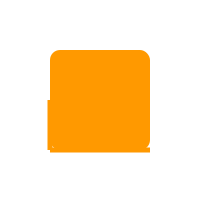

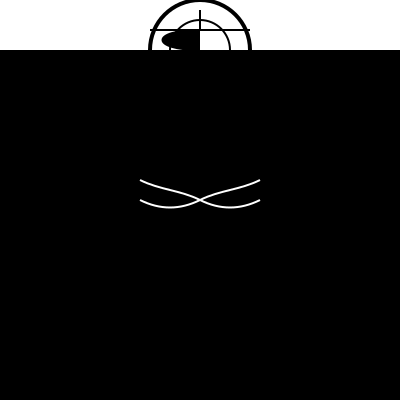

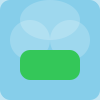

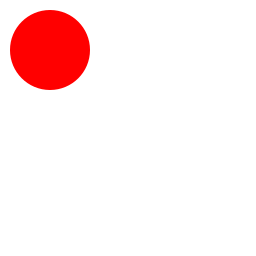

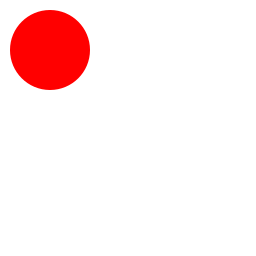

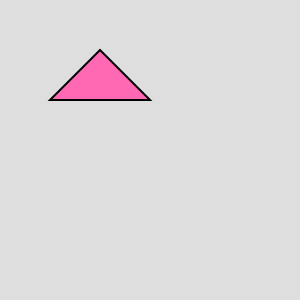

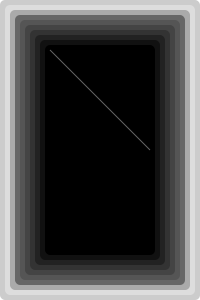

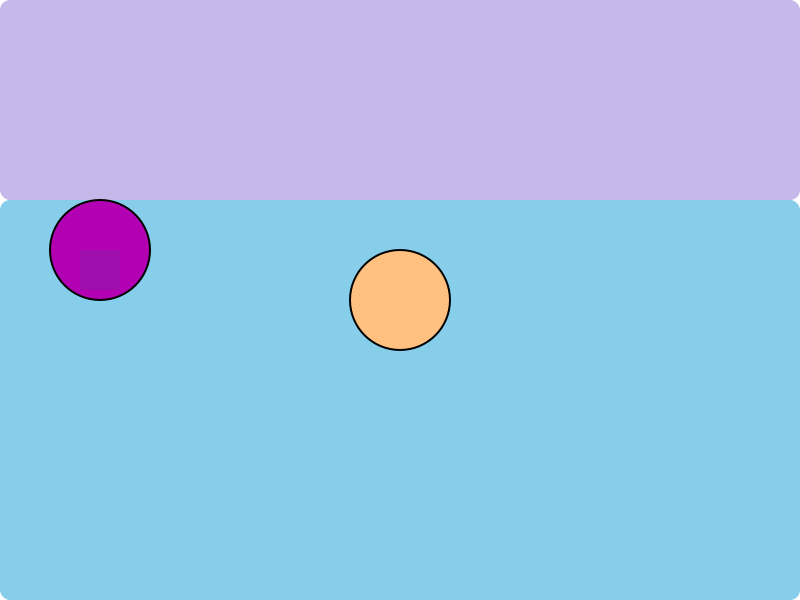

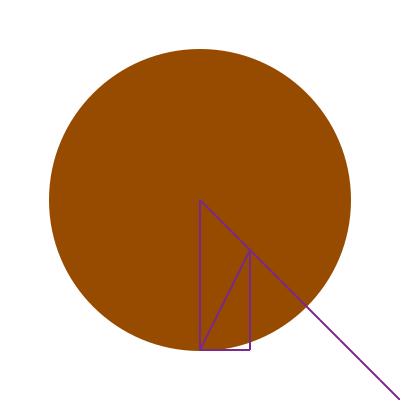

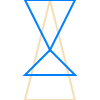

In [19]:
# We can play with our Model and render its SVG output (don't export!)
from IPython.display import SVG, display
for i in range(15):
    display(SVG(train.loc[i,'svg_code_clean']))

In [23]:
from transformers import AutoProcessor, AutoModel
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

In [24]:
import torch
from PIL import Image
import cairosvg
import os

def svgMetric(prompt, svg):
    try:
        # Convert SVG to PNG
        cairosvg.svg2png(svg, write_to="./tmp/temp.png")
        
        # Open and process the image
        image = Image.open('./tmp/temp.png').convert("RGB")
        texts = ["SVG illustration of " + prompt]
        inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")
        
        # Inference without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits_per_image = outputs.logits_per_image
        probs = torch.sigmoid(logits_per_image)
        
        # Clean up temporary PNG file
        #os.remove('./tmp/temp.png')
        
        return probs[0][0].item()

    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None




In [25]:
# Using apply to process each row in the DataFrame
train['score1'] = train.apply(lambda row: svgMetric(row['description'], row['svg_code']), axis=1)
train['score2'] = train.apply(lambda row: svgMetric(row['description'], row['svg_code_clean']), axis=1)

An error occurred: The SVG size is undefined
An error occurred: The SVG size is undefined


In [26]:
train[['score1','score2']].mean()

score1    0.104248
score2    0.165968
dtype: float64

In [27]:
train['score1']

0     4.347312e-03
1     5.451384e-05
2     9.813819e-01
3     1.429424e-10
4     5.016658e-06
5     1.271884e-03
6     3.971813e-02
7              NaN
8     6.303957e-10
9     4.507666e-11
10    2.699434e-02
11    9.717740e-06
12    7.180350e-06
13    2.545882e-01
14    1.510933e-01
Name: score1, dtype: float64

In [28]:
train['score2']

0     9.678911e-04
1     5.451384e-05
2     9.813819e-01
3     1.429424e-10
4     5.016658e-06
5     1.271884e-03
6     3.971813e-02
7              NaN
8     6.303957e-10
9     4.507666e-11
10    8.944473e-01
11    9.717740e-06
12    7.180350e-06
13    2.545882e-01
14    1.510933e-01
Name: score2, dtype: float64

In [29]:
train['svg_code_clean']

0     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
1     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
2     <svg xmlns="http://www.w3.org/2000/svg" width=...
3     <svg width="256" height="256" viewBox="0 0 256...
4     <svg xmlns="http://www.w3.org/2000/svg" width=...
5     <svg xmlns="http://www.w3.org/2000/svg" width=...
6     <svg xmlns="http://www.w3.org/2000/svg" viewBo...
7     <svg xmlns="http://www.w3.org/2000/svg" width=...
8     <svg width="256" height="256" viewBox="0 0 256...
9     <svg width="256" height="256" viewBox="0 0 256...
10    <svg xmlns="http://www.w3.org/2000/svg" width=...
11    <svg width="200" height="300"><rect x="0" y="0...
12    <svg xmlns="http://www.w3.org/2000/svg" width=...
13    <svg xmlns="http://www.w3.org/2000/svg" width=...
14    <svg xmlns="http://www.w3.org/2000/svg" width=...
Name: svg_code_clean, dtype: object